In [ ]:
# Goal: Topic Modeling on Dear Abby questions using LDA and NMF algorithms
# 
# Summary:
#    Use Latent Dirichlet Allocation (LDA) and Non-negative matrix factorization (NMF) to 
#    generate topics from over 20,000 Dear Abby questions from 1985-2017. Based on
#    coherence scores, an ideal number of topics could be 2, 3, 4, or 21.  Tried 2, 4 and 21
#    topics, depending on the model. 
#    LDA generally found common themes throughout all questions of time, husbands, mothers, family
#    with different weightings of those themes in different topic groupings
#    However, the most interesting results came from NMF with 21 topics.
#    Topics included:
#     - marriage & divorce
#     - son and daughter worries
#     - husbands, marriage and affairs
#     - weddings
#     - children
#     - friend issues
#     - school, high school/college, graduation, students
#     - love, relationships, boyfriends, heart break
#     - pregnancy and having babies, adoption
#     - work, money, offices, bosses, college
#     - engagement stuff, like rings, dress, jewelry
#     - pets and neighbor's pets
#     - dating, attraction, sex
#     - brothers, sisters, holidays
#     - etc...
#
# Data Source: 
#    American Anxieties: Dear Abby's Questions
#    20,000 Questions to Dear Abby: Insights on American Anxieties
#    By Kelly Garrett
#    https://www.kaggle.com/datasets/thedevastator/american-anxieties-dear-abby-s-questions
#
# Date last updated: 2/9/2024
# Author: Kay Rubio

In [ ]:
# Install packages as needed:
# !pip3 install contractions
# !pip install certifi
# !pip3 install --upgrade certifi
# !pip3 install wordcloud
# !pip3 install gensim
# !pip3 install pyLDAvis

In [1]:
from collections import Counter
import contractions
import gensim
from gensim.models import CoherenceModel
import joblib
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
import numpy as np
import os
from os import path
import pandas as pd
import pickle 
from PIL import Image
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
import re
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package wordnet to /Users/KRubio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/KRubio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
# Import data
df = pd.read_csv("./dear_abby.csv")

In [53]:
df.head()

,index,year,month,day,url,title,letterId,question_only
0,0,1985,1.0,1,proquest,WOMAN NEEDS HELP: HER BURDEN OF HOPELESSNESS I...,1,i have been in a bad marriage for 40 years. i ...
1,1,1985,1.0,1,proquest,WOMAN NEEDS HELP: HER BURDEN OF HOPELESSNESS I...,1,"this is for all newspaper carriers, mail carri..."
2,2,1985,1.0,2,proquest,LAMENT ABOUT OLD AGE AND SICKNESS IS ILL-ADVISED,1,our 16-year-old son recently was placed in a s...
3,3,1985,1.0,3,proquest,'NORMAL' WIDOW HAS AN EYE FOR THE GUYS,1,"i was a happy, respectable wife for 40 years, ..."
4,4,1985,1.0,4,proquest,IT'S WISE TO BE WARY WHEN A STRANGER COMES TO ...,1,you be the judge: last night about 7 p.m. i wa...


In [54]:
# Keep only year and question columns. Rename question
df = df[['year', 'question_only']].copy()
df.rename(columns={'question_only':'question'}, inplace=True)
df.head()

,year,question
0,1985,i have been in a bad marriage for 40 years. i ...
1,1985,"this is for all newspaper carriers, mail carri..."
2,1985,our 16-year-old son recently was placed in a s...
3,1985,"i was a happy, respectable wife for 40 years, ..."
4,1985,you be the judge: last night about 7 p.m. i wa...


In [55]:
# Check number of rows
print('Rows: {}'.format(len(df)))

Rows: 20034


In [56]:
# Clean text, remove punctuation, extra stuff that's not part of the question, symbols, numbers
# and expand contractions
def clean_text(text):
    # Convert to lower case in case it's not already
    text = text.lower()
        
    # Quite a few of the questions have this phrase that's not part of the content:
    text = text.replace("reproduced with permission of the copyright owner", "")
    text = text.replace("further reproduction prohibited without permission", "")

    # Quite a few of them have an ending statement suggesting getting Abby's "booklet" with 
    # a bunch more infor after that like the name of a booklet, directions for money order, etc.
    # but that text isn't consistent. Chop off anything after and including the word "booklet"
    parts = text.split("booklet", 1)
    text = parts[0]
    
    # Remove symbols that are meant to be ' or "
    text = text.replace("äô", "'")
    text = text.replace("äù", " ")
    text = text.replace("äú", " ")
    text = text.replace("äò", "'")
    text = text.replace("äî", " ")
    text = text.replace("äú", " ")

    # Replace dashes with space to avoid smushed together words
    text = text.replace("-", " ")

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)
    
    # Expand contractions
    expanded_text = []   
    for word in text.split():
      expanded_text.append(contractions.fix(word))  
    text = ' '.join(expanded_text)

    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text = text.replace("‚", "")

    return text

df.loc[:, 'clean'] = df['question'].apply(lambda x: clean_text(x))

In [57]:
df.head()

,year,question,clean
0,1985,i have been in a bad marriage for 40 years. i ...,i have been in a bad marriage for years i knew...
1,1985,"this is for all newspaper carriers, mail carri...",this is for all newspaper carriers mail carrie...
2,1985,our 16-year-old son recently was placed in a s...,our year old son recently was placed in a stat...
3,1985,"i was a happy, respectable wife for 40 years, ...",i was a happy respectable wife for years and n...
4,1985,you be the judge: last night about 7 p.m. i wa...,you be the judge last night about pm i was rel...


In [216]:
# Check some of the results
print('ORIGINAL 416')
print(df.at[416, 'question'])
print()
print('CLEANED 416') 
print(df.at[416, 'clean'])
print()

print('ORIGINAL 580')
print(df.at[580, 'question'])
print()
print('CLEANED 580') 
print(df.at[580, 'clean'])
print()

print('ORIGINAL 633')
print(df.at[633, 'question'])
print()
print('CLEANED 633') 
print(df.at[633, 'clean'])
print()

ORIGINAL 416
i am newly married to a woman i'll call edith. it's the second time around for both of us. now for the problem:
when we make love, edith makes me wear an undershirt. why? because i have "gretchen" tattooed on my chest above my heart. (gretchen was my first wife.)
edith knew i had gretchen on my chest when she married me, but it didn't bother her. now, it's either cover up gretchen or no lovemaking. i am not used to wearing anything to bed, but unless i want to go right to sleep i have to wear an undershirt.
is there some way to remove a tattoo? i've had it since i was 20, and now i'm 41.
henry in elizabeth, n.j.

CLEANED 416
i am newly married to a woman i will call edith it is the second time around for both of us now for the problem when we make love edith makes me wear an undershirt why because i have gretchen tattooed on my chest above my heart gretchen was my first wife edith knew i had gretchen on my chest when she married me but it did not bother her now it is eithe

In [60]:
# Define a function that will tokenize text
def tokenize(text):
    text_list = nltk.WordPunctTokenizer().tokenize(text)
    return text_list

In [62]:
# Define a function that will lemmatize text using nltk's WordNetLemmatizer
def lemmatize(text_list):
    text_list = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text_list if len(token)>1]
    return text_list

In [61]:
# define stopwords for english
stopwords_list = stopwords.words('english')

In [63]:
# Define a function that will remove stopwords from tokenized text
def remove_stopwords(text_list):
    text_list = [word for word in text_list if word not in stopwords_list]
    return text_list

In [64]:
# Define a function that will remove the tokenization and return to a regular text string
def remove_tokenization(text_list):
    text = ' '.join(map(str, text_list))
    return text

In [65]:
# apply tokenization, remove stopwords, lemmatize and save each result in new columns
df.loc[:, 'tokenized'] = df['clean'].apply(lambda x: tokenize(x))
df.loc[:, 'lemma'] = df['tokenized'].apply(lambda x: lemmatize(x))
df.loc[:, 'no_stopwords'] = df['lemma'].apply(lambda x: remove_stopwords(x))

# make a column without tokenization for ease of reading and word frequency below
df.loc[:, 'new_text'] = df['no_stopwords'].apply(lambda x: remove_tokenization(x))

In [66]:
df.head()

,year,question,clean,tokenized,lemma,no_stopwords,new_text
0,1985,i have been in a bad marriage for 40 years. i ...,i have been in a bad marriage for years i knew...,"[i, have, been, in, a, bad, marriage, for, yea...","[have, be, in, bad, marriage, for, years, know...","[bad, marriage, years, know, mistake, first, y...",bad marriage years know mistake first year cat...
1,1985,"this is for all newspaper carriers, mail carri...",this is for all newspaper carriers mail carrie...,"[this, is, for, all, newspaper, carriers, mail...","[this, be, for, all, newspaper, carriers, mail...","[newspaper, carriers, mail, carriers, delivery...",newspaper carriers mail carriers delivery peop...
2,1985,our 16-year-old son recently was placed in a s...,our year old son recently was placed in a stat...,"[our, year, old, son, recently, was, placed, i...","[our, year, old, son, recently, be, place, in,...","[year, old, son, recently, place, state, facil...",year old son recently place state facility man...
3,1985,"i was a happy, respectable wife for 40 years, ...",i was a happy respectable wife for years and n...,"[i, was, a, happy, respectable, wife, for, yea...","[be, happy, respectable, wife, for, years, and...","[happy, respectable, wife, years, lonely, resp...",happy respectable wife years lonely respectabl...
4,1985,you be the judge: last night about 7 p.m. i wa...,you be the judge last night about pm i was rel...,"[you, be, the, judge, last, night, about, pm, ...","[you, be, the, judge, last, night, about, pm, ...","[judge, last, night, pm, relax, tub, doorbell,...",judge last night pm relax tub doorbell ring ex...


In [217]:
# Check some of the results
print('ORIGINAL 417')
print(df.at[417, 'question'])
print()
print('NEW 417') 
print(df.at[417, 'new_text'])
print()

print('ORIGINAL 10003')
print(df.at[10003, 'question'])
print()
print('NEW 10003') 
print(df.at[10003, 'new_text'])
print()

print('ORIGINAL 20032')
print(df.at[20032, 'question'])
print()
print('NEW 20032') 
print(df.at[20032, 'new_text'])
print()

ORIGINAL 417
a very dear friend of mine is having an affair with a married man. she divorced her husband of 14 years to be free for "joe." joe lived with my friend for a few months, then moved back home because his children "needed" him. joe goes to my friend's place three or four mornings a week for coffee and sex. the rest of the time he is with his wife. joe has given my friend some expensive gifts and takes her on some business trips, which is all she lives for. she's beautiful and smart and has everything going for her. i've tried to tell her she's wasting her time, but she says she loves joe and he's worth waiting for.
i know you get lots of letters from women who are waiting for married men to leave their wives. can you send me a few dozen? if i show them to my friend, she may see the light. thanks.
all talked out in dallas

NEW 417
friend mine affair marry man divorce husband years free joe joe live friend months move home children joe friends place four mornings week coffee se

In [119]:
# Explore word count of tokenized and lemmatized columns
df['word_count'] = df['tokenized'].apply(lambda x: len(x))
df['word_count_lemma'] = df['lemma'].apply(lambda x: len(x))

df.head()

,year,question,clean,tokenized,lemma,no_stopwords,new_text,word_count,word_count_lemma
0,1985,i have been in a bad marriage for 40 years. i ...,i have been in a bad marriage for years i knew...,"[i, have, been, in, a, bad, marriage, for, yea...","[have, be, in, bad, marriage, for, years, know...","[bad, marriage, years, mistake, year, catholic...",bad marriage years mistake year catholic accep...,122,108
1,1985,"this is for all newspaper carriers, mail carri...",this is for all newspaper carriers mail carrie...,"[this, is, for, all, newspaper, carriers, mail...","[this, be, for, all, newspaper, carriers, mail...","[newspaper, carriers, mail, carriers, delivery...",newspaper carriers mail carriers delivery peop...,136,131
2,1985,our 16-year-old son recently was placed in a s...,our year old son recently was placed in a stat...,"[our, year, old, son, recently, was, placed, i...","[our, year, old, son, recently, be, place, in,...","[year, old, son, recently, place, state, facil...",year old son recently place state facility pro...,86,83
3,1985,"i was a happy, respectable wife for 40 years, ...",i was a happy respectable wife for years and n...,"[i, was, a, happy, respectable, wife, for, yea...","[be, happy, respectable, wife, for, years, and...","[happy, respectable, wife, years, lonely, resp...",happy respectable wife years lonely respectabl...,164,146
4,1985,you be the judge: last night about 7 p.m. i wa...,you be the judge last night about pm i was rel...,"[you, be, the, judge, last, night, about, pm, ...","[you, be, the, judge, last, night, about, pm, ...","[judge, night, pm, relax, tub, doorbell, ring,...",judge night pm relax tub doorbell ring expect ...,235,210


In [126]:
df['word_count'].describe()

count    20034.000000
mean       146.490816
std         91.110973
min          4.000000
25%         94.000000
50%        136.000000
75%        182.000000
max       2537.000000
Name: word_count, dtype: float64

(array([9.310e+03, 9.506e+03, 9.580e+02, 1.330e+02, 6.400e+01, 2.500e+01,
        1.200e+01, 7.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([   4.  ,  130.65,  257.3 ,  383.95,  510.6 ,  637.25,  763.9 ,
         890.55, 1017.2 , 1143.85, 1270.5 , 1397.15, 1523.8 , 1650.45,
        1777.1 , 1903.75, 2030.4 , 2157.05, 2283.7 , 2410.35, 2537.  ]),
 <BarContainer object of 20 artists>)

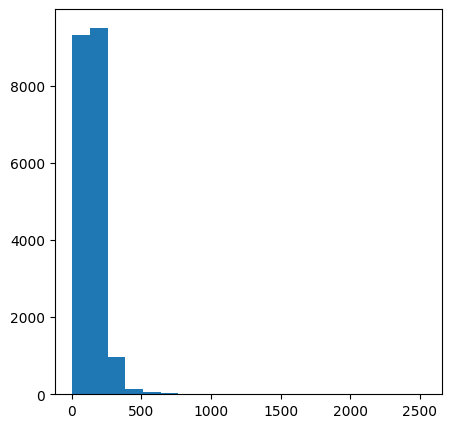

In [122]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df['word_count'],
    bins=20,
)

In [127]:
df['word_count_lemma'].describe()

count    20034.000000
mean       136.504393
std         86.376538
min          3.000000
25%         87.000000
50%        126.000000
75%        169.000000
max       2428.000000
Name: word_count_lemma, dtype: float64

In [132]:
# Tokenized columns have avg of 147 words, but some extreme outliers with over 2000 words
# After lemmatization, avg of 137 words

# Look at rows with over 1000 words, since these may be in error

# All rows with word_count over 1000, just clean column
long_questions = df[df['word_count'] > 1000]
long_questions = long_questions[['question', 'word_count']].copy()
long_questions

,question,word_count
57,prime-time tv is about to do gays the way they...,1158
347,it's 10 a.m. and the crowd hasn't arrived yet ...,1511
389,six months after dr. michael salesin became th...,1210
536,when nude photographs of madonna appeared in t...,1415
1190,there are certain roles that mark a performer ...,1388
1332,denise salvaggio's dream is to do for bugs wha...,1508
1900,in one of his more notorious discursions into ...,1298
1917,sometimes when i am near my wife she breaks ou...,1021
2080,"¬† four times a year, in either joan muffler's...",1004
2551,"media-wise, this is going to be a tough campai...",2537


In [136]:
# There are 20 questions here that are over 1000 words. What's making them so long?
# print(df.at[6043, 'question'])
# After printing out some of these, looks like they might be full opinion pieces from the newspaper 
# rather than individual dear abby questions. Cut them out of dataset
df = df[df['word_count'] < 1000]

In [137]:
# Function to find out most frequent words in a column of non-tokenized text
def show_most_frequent_words(column):
    all_questions = ','.join(df[column].astype(str).values)
    
    # Count each word
    counter = Counter(all_questions.split())
    most_frequent = counter.most_common(30)

    # Plot the most frequent words
    fig = plt.figure(1, figsize = (20,10))
    _ = pd.DataFrame(most_frequent, columns=("words","count"))
    sns.barplot(x = 'words', y = 'count', data = _, hue='words', palette='winter')
    plt.xticks(rotation=45);

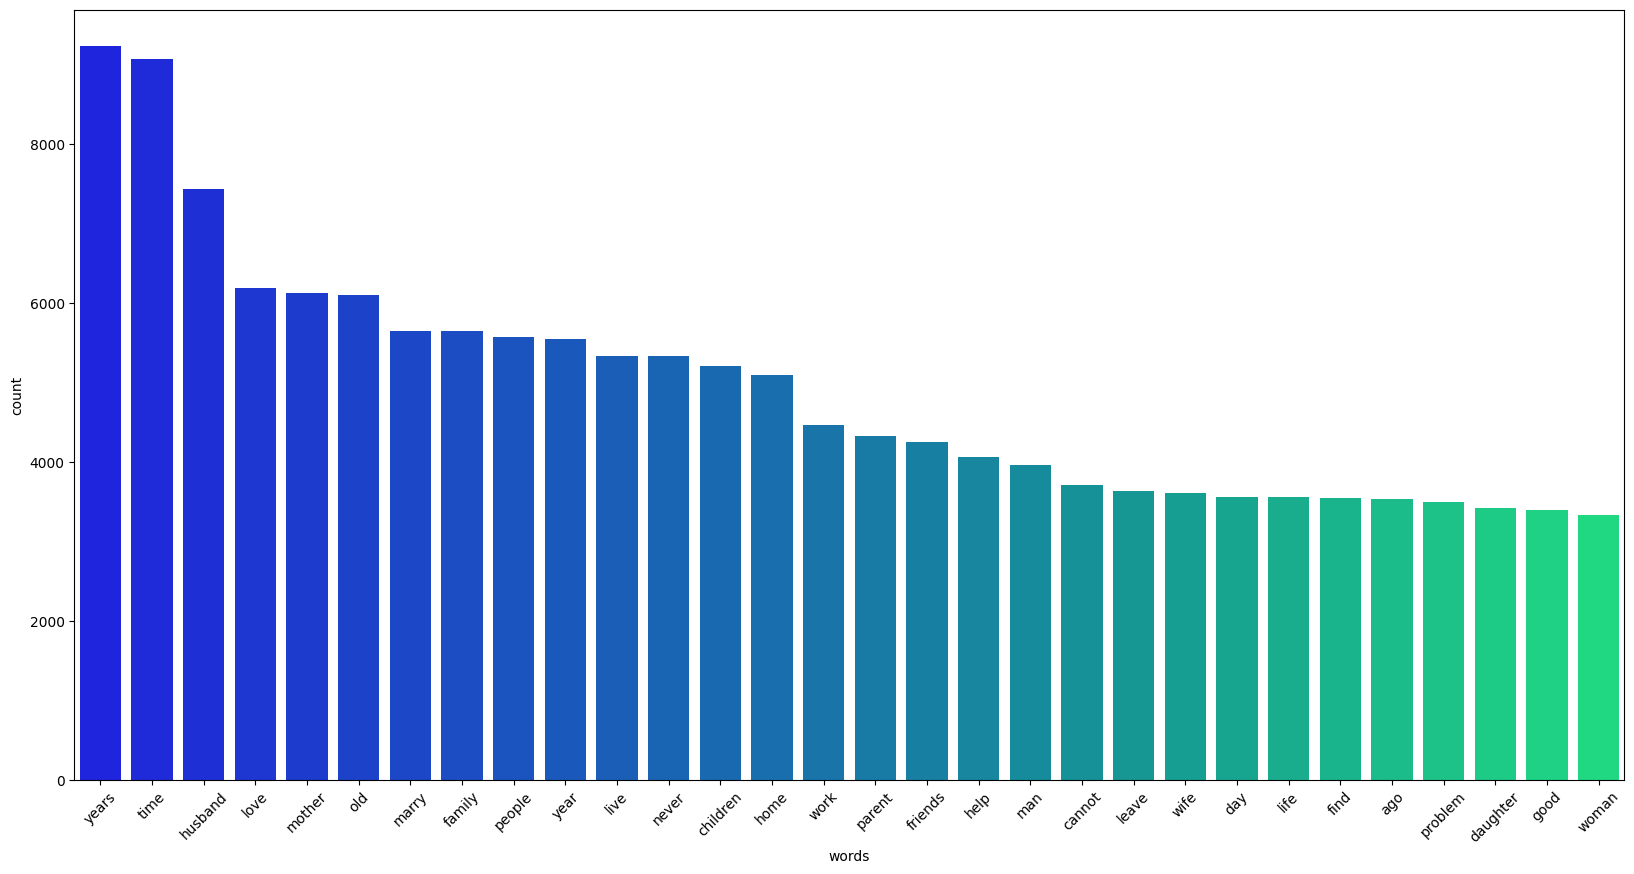

In [138]:
show_most_frequent_words('new_text')

In [139]:
# Print out a list of these most common words to see more of them
all_questions = ','.join(df['new_text'].astype(str).values)
    
# Count each word
counter = Counter(all_questions.split())
most_frequent = counter.most_common(100)

print(most_frequent)

[('years', 9232), ('time', 9073), ('husband', 7440), ('love', 6194), ('mother', 6133), ('old', 6099), ('marry', 5655), ('family', 5648), ('people', 5573), ('year', 5554), ('live', 5340), ('never', 5338), ('children', 5214), ('home', 5097), ('work', 4466), ('parent', 4330), ('friends', 4257), ('help', 4063), ('man', 3967), ('cannot', 3710), ('leave', 3635), ('wife', 3614), ('day', 3562), ('life', 3561), ('find', 3546), ('ago', 3537), ('problem', 3494), ('daughter', 3427), ('good', 3393), ('woman', 3339), ('wed', 3164), ('son', 3155), ('father', 3092), ('always', 3044), ('friend', 2850), ('well', 2838), ('new', 2796), ('child', 2722), ('right', 2716), ('school', 2713), ('gift', 2625), ('since', 2558), ('together', 2486), ('house', 2464), ('mom', 2456), ('pay', 2412), ('relationship', 2410), ('months', 2349), ('kid', 2326), ('money', 2323), ('marriage', 2265), ('move', 2239), ('things', 2203), ('without', 2201), ('put', 2172), ('hurt', 2158), ('meet', 2146), ('send', 2144), ('baby', 2140)

In [140]:
# Lets get rid of some of the more generic words by adding to the stopword list
# Everyone says stuff, wants stuff, goes places, knows, thinks, likes, feels, asks... these are generic
# Some words are also common due to the nature of this being dear abby, remove those as well
stopwords_list.extend(['would', 'say', 'get', 'want', 'tell', 'go', 'know', 'think', 'like', 'make', 'feel', 'ask', 'take', 'abby', 'dear', 'one', 'two', 'call', 'see', 'come', 'could', 'even', 'try', 'way', 'please', 'also', 'talk', 'much', 'use', 'last', 'keep', 'look', 'still', 'every', 'back', 'first', 'many', 'three', 'something', 'someone', 'let', 'name', 'write', 'date', 'start', 'another', 'become', 'us', 'give', 'need',])

# Overwrite the existing columns with this updated stopwords removal for simplicity
df.loc[:, 'lemma'] = df['tokenized'].apply(lambda x: lemmatize(x))
df.loc[:, 'no_stopwords'] = df['lemma'].apply(lambda x: remove_stopwords(x))
df.loc[:, 'new_text'] = df['no_stopwords'].apply(lambda x: remove_tokenization(x))

In [141]:
df.head()

,year,question,clean,tokenized,lemma,no_stopwords,new_text,word_count,word_count_lemma
0,1985,i have been in a bad marriage for 40 years. i ...,i have been in a bad marriage for years i knew...,"[i, have, been, in, a, bad, marriage, for, yea...","[have, be, in, bad, marriage, for, years, know...","[bad, marriage, years, mistake, year, catholic...",bad marriage years mistake year catholic accep...,122,108
1,1985,"this is for all newspaper carriers, mail carri...",this is for all newspaper carriers mail carrie...,"[this, is, for, all, newspaper, carriers, mail...","[this, be, for, all, newspaper, carriers, mail...","[newspaper, carriers, mail, carriers, delivery...",newspaper carriers mail carriers delivery peop...,136,131
2,1985,our 16-year-old son recently was placed in a s...,our year old son recently was placed in a stat...,"[our, year, old, son, recently, was, placed, i...","[our, year, old, son, recently, be, place, in,...","[year, old, son, recently, place, state, facil...",year old son recently place state facility pro...,86,83
3,1985,"i was a happy, respectable wife for 40 years, ...",i was a happy respectable wife for years and n...,"[i, was, a, happy, respectable, wife, for, yea...","[be, happy, respectable, wife, for, years, and...","[happy, respectable, wife, years, lonely, resp...",happy respectable wife years lonely respectabl...,164,146
4,1985,you be the judge: last night about 7 p.m. i wa...,you be the judge last night about pm i was rel...,"[you, be, the, judge, last, night, about, pm, ...","[you, be, the, judge, last, night, about, pm, ...","[judge, night, pm, relax, tub, doorbell, ring,...",judge night pm relax tub doorbell ring expect ...,235,210


In [218]:
# Check some of the results
print('ORIGINAL 15000')
print(df.at[15000, 'question'])
print()
print('NEW 15000') 
print(df.at[15000, 'new_text'])
print()

print('ORIGINAL 18000')
print(df.at[18000, 'question'])
print()
print('NEW 18000') 
print(df.at[18000, 'new_text'])
print()

print('ORIGINAL 20033')
print(df.at[20033, 'question'])
print()
print('NEW 20033') 
print(df.at[20033, 'new_text'])
print()

ORIGINAL 15000
my husband and i divorced several years ago because of his cocaine habit. he had been taking money from our accounts, etc.
after our divorce i met someone. it was several months before i agreed to a date. he's honest, fun, good-looking, hardworking and helps my family when he can. my problem is on our first date he told me he'd been a drug user and had spent time in prison. he said that was in the past. he got counseling, loves his new life and would not break the law again.
my children know about his past and say, "it's no big deal; it's the 21st century." we date, nothing more, but he alludes to wanting to propose. i'm afraid that when my parents and people in my small town find out about his past, they'll be shocked and i'll be shunned. i can't believe this is an issue in my life again.
is it ok to date an ex-drug addict? do some people beat the odds and stay clean? i'm scared that maybe i should have run away after that first date. please advise. -- waiting for the o

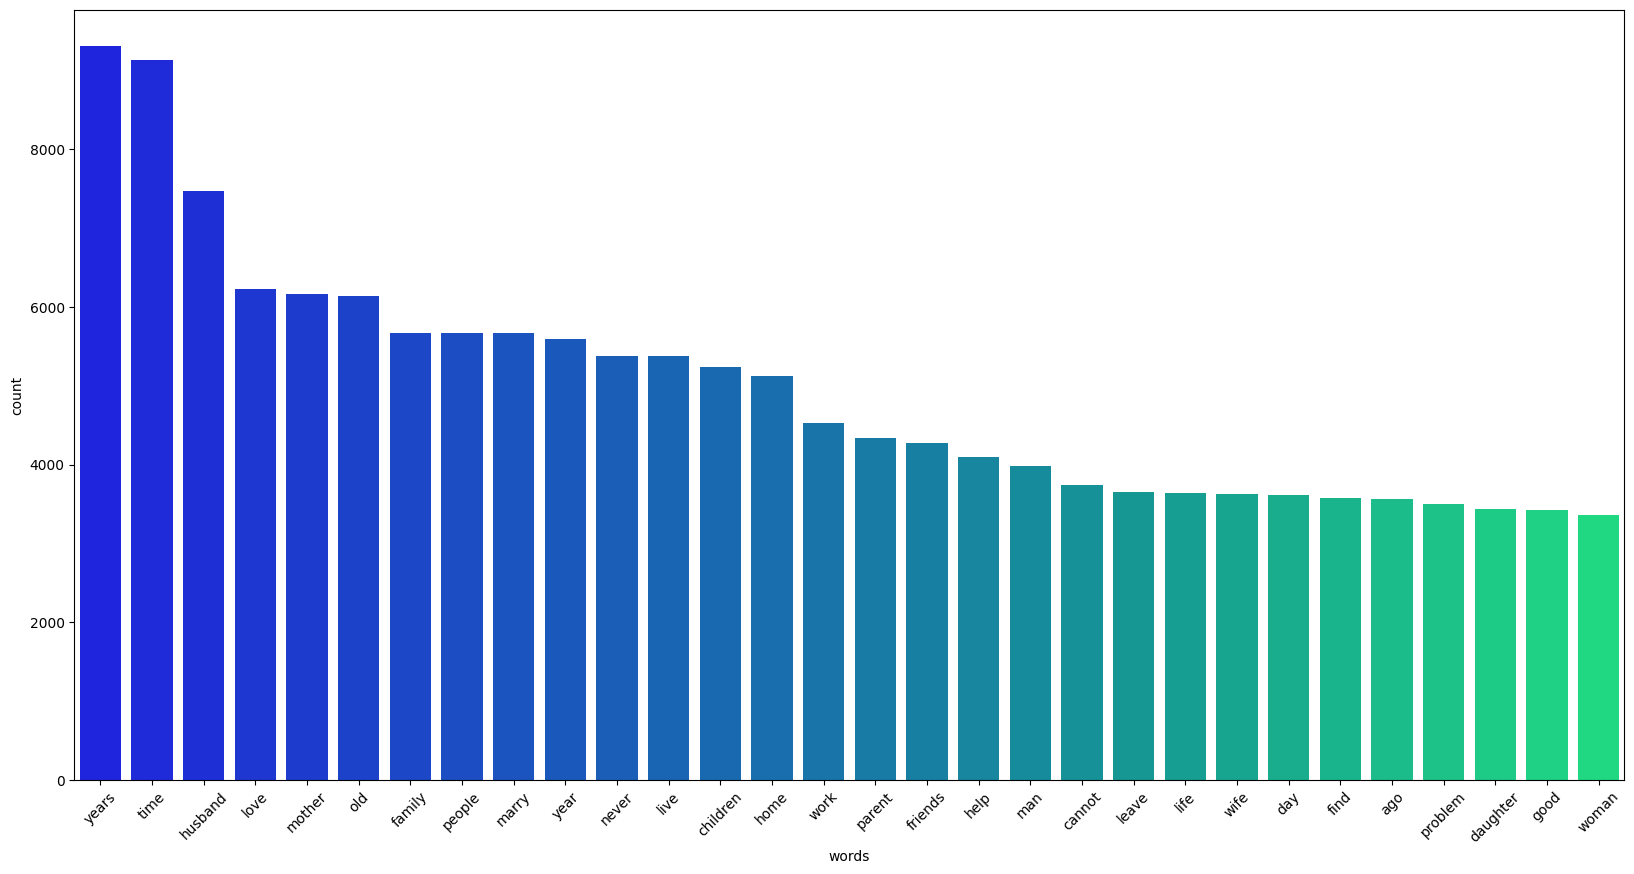

In [81]:
# See what words are most frequent now
show_most_frequent_words('new_text')

In [143]:
# These look like useful topic words, not as generic

In [144]:
# Define a function that can generate and print a word cloud
def make_word_cloud(column):
    all_questions = ','.join(df[column].astype(str).values)
    # Generate the word cloud
    wordcloud = WordCloud(background_color="white",
                      max_words= 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(all_questions)
                      
    # Visualize the word cloud
    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()


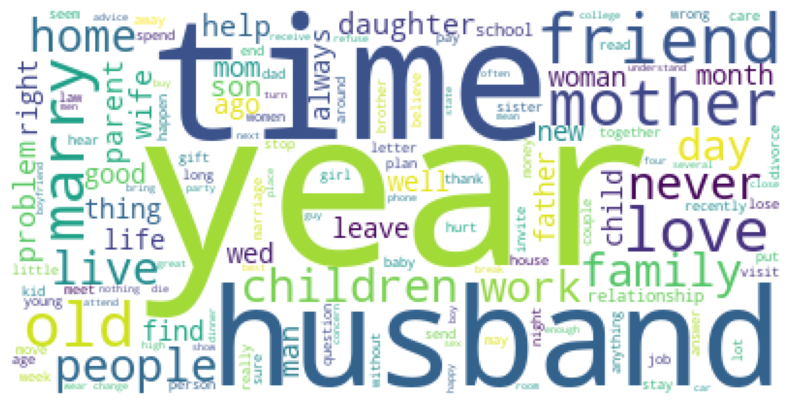

In [145]:
make_word_cloud('new_text')

In [ ]:
# That's a pretty cool word cloud!  People are very concerned about time, along with husbands
# also common topics are friends, mothers, family, love, etc.  

In [84]:
# Topic modeling with an LDA algorithm
# Create Dictionary on tokenized column in df
id2word = gensim.corpora.Dictionary(df['no_stopwords'])

In [85]:
print(id2word)

Dictionary<27073 unique tokens: ['accept', 'accident', 'bad', 'bore', 'catholic']...>


In [146]:
len(id2word)

27073

In [86]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['no_stopwords']]

In [103]:
# Ran this several times with some trial and error to find best coherence, checking up through 50
# But looks like highest coherence is between 1 and 5, or between 20-30

# Compute Coherence Score
number_of_topics = []
coherence_score = []

potentialTopics = [1, 2, 3, 4, 5, 10, 15, 20, 21, 22, 23, 23, 25, 26, 27, 28, 29, 30, 35, 40]
for i in potentialTopics:
#for i in range(1,10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=df['no_stopwords'], dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda);

In [104]:
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})

In [105]:
topic_coherence

,number_of_topics,coherence_score
0,1,0.432082
1,2,0.425944
2,3,0.377934
3,4,0.413887
4,5,0.394140
5,10,0.376145
6,15,0.368915
7,20,0.382986
8,21,0.387110
9,22,0.381745


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

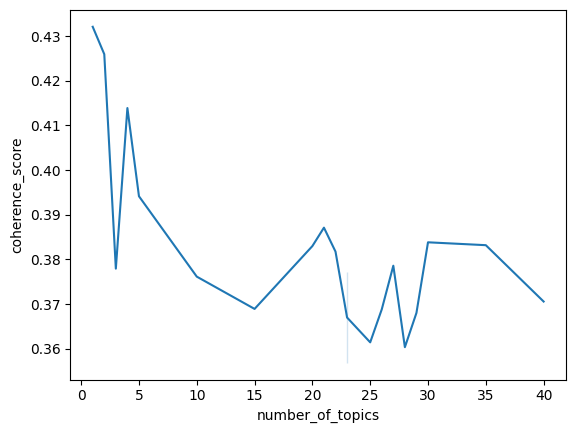

In [106]:
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [ ]:
# Best coherence would be with 1, 2, 4, 5, or 21 topics

In [222]:
# Topics Model with LDA algorithm using 2 topics
num_topics = 2
# Build LDA model
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 2 topics
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

[(0,
  '0.009*"time" + 0.007*"years" + 0.007*"husband" + 0.007*"mother" + '
  '0.007*"year" + 0.006*"marry" + 0.006*"live" + 0.006*"old" + 0.006*"work" + '
  '0.005*"family"'),
 (1,
  '0.011*"years" + 0.009*"husband" + 0.009*"time" + 0.007*"love" + '
  '0.006*"year" + 0.006*"people" + 0.006*"family" + 0.005*"old" + '
  '0.005*"friends" + 0.005*"never"')]


In [ ]:
# Both are about time, husbands, love, marriage, and mothers

In [109]:
# Topics Model with LDA algorithm using 5 topics
num_topics = 5
# Build LDA model
lda_model_5 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model_5.print_topics())
doc_lda = lda_model_5[corpus]

[(0,
  '0.012*"years" + 0.011*"time" + 0.010*"husband" + 0.007*"year" + '
  '0.006*"love" + 0.006*"wife" + 0.006*"family" + 0.005*"people" + 0.005*"old" '
  '+ 0.005*"home"'),
 (1,
  '0.009*"years" + 0.008*"daughter" + 0.007*"old" + 0.007*"love" + '
  '0.006*"never" + 0.006*"year" + 0.006*"time" + 0.006*"marry" + '
  '0.006*"people" + 0.005*"husband"'),
 (2,
  '0.010*"years" + 0.008*"time" + 0.006*"people" + 0.006*"love" + 0.006*"old" '
  '+ 0.006*"family" + 0.006*"husband" + 0.006*"live" + 0.006*"work" + '
  '0.005*"day"'),
 (3,
  '0.010*"husband" + 0.009*"years" + 0.009*"mother" + 0.009*"time" + '
  '0.008*"year" + 0.008*"marry" + 0.007*"live" + 0.007*"children" + '
  '0.007*"family" + 0.007*"son"'),
 (4,
  '0.010*"time" + 0.008*"husband" + 0.007*"never" + 0.007*"year" + '
  '0.006*"love" + 0.006*"cannot" + 0.005*"years" + 0.005*"people" + '
  '0.005*"family" + 0.005*"mother"')]


In [ ]:
# Similar as above, but got some other themes here too like daughters, sons, children, work and family
# However hard to see them as distinct - lots of overlap. Different more in their weightings
# of the same topics

In [110]:
# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_5, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.010383 -0.006865       1        1  29.829032
2      0.006238 -0.004991       2        1  20.517407
0      0.000114 -0.001724       3        1  18.350823
1      0.001000  0.018331       4        1  16.587738
4     -0.017736 -0.004751       5        1  14.715000, topic_info=         Term         Freq        Total Category  logprob  loglift
424  daughter  3791.000000  3791.000000  Default  30.0000  30.0000
135      wife  4084.000000  4084.000000  Default  29.0000  29.0000
107      good  3388.000000  3388.000000  Default  28.0000  28.0000
25      never  5348.000000  5348.000000  Default  27.0000  27.0000
221      time  9452.000000  9452.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
235     marry   595.086130  5942.397700   Topic5  -5.5912  -0.3849
82       home   542.575040  5023.929725   Topic5  -5.6836  -0.3093
332    parent   505.335905  4604.690424   Topic5  -5.7547  -0.2933
93   recently   453.539772  3007.216912   Topic5  -5.8628   0.0246
574      find   452.739244  3554.004253   Topic5  -5.8646  -0.1442

[454 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
612        1  0.302080  afraid
612        2  0.224333  afraid
612        3  0.110952  afraid
612        4  0.281833  afraid
612        5  0.081796  afraid
...      ...       ...     ...
142        3  0.207394   young
142        4  0.138262   young
142        5  0.115638   young
18150      1  0.340936     zsa
18150      5  0.568226     zsa

[1021 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5])

In [ ]:
# From 5 topics:
# To summarize by putting some human meaning on this:
#    Time is a universal theme
#    A husband cluster (1) with a lot of discussion of mothers, marriage, children, family
#    A generic family cluster (2) with husbands and time, but also mentions work and money
#    A wives and husbands cluster (3) with love
#    A daughter cluster (4) with themes related to love and marriage 
#    Another husband cluster (5) with a lot of other family terms

In [111]:
# Topics Model with LDA algorithm using 21 topics
num_topics = 21
# Build LDA model
lda_model_21 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 21 topics
pprint(lda_model_21.print_topics())
doc_lda = lda_model_21[corpus]

[(15,
  '0.015*"husband" + 0.013*"years" + 0.011*"time" + 0.008*"year" + '
  '0.007*"cannot" + 0.007*"family" + 0.006*"mother" + 0.006*"live" + '
  '0.006*"old" + 0.006*"wife"'),
 (20,
  '0.011*"husband" + 0.008*"years" + 0.007*"people" + 0.007*"home" + '
  '0.007*"time" + 0.007*"old" + 0.006*"daughter" + 0.006*"year" + '
  '0.005*"family" + 0.005*"children"'),
 (7,
  '0.012*"years" + 0.008*"home" + 0.008*"time" + 0.008*"mother" + '
  '0.007*"never" + 0.007*"live" + 0.006*"husband" + 0.006*"marry" + '
  '0.006*"old" + 0.006*"love"'),
 (2,
  '0.014*"years" + 0.011*"year" + 0.008*"husband" + 0.008*"live" + '
  '0.007*"mother" + 0.006*"time" + 0.006*"marry" + 0.006*"friends" + '
  '0.005*"move" + 0.005*"life"'),
 (9,
  '0.013*"mother" + 0.011*"husband" + 0.009*"time" + 0.009*"love" + '
  '0.008*"children" + 0.007*"years" + 0.007*"child" + 0.007*"wed" + '
  '0.006*"son" + 0.006*"marry"'),
 (4,
  '0.010*"time" + 0.007*"mother" + 0.007*"home" + 0.007*"husband" + '
  '0.006*"family" + 0.006*"

In [112]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_21, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.003462 -0.001480       1        1  9.010295
15     0.000215  0.001483       2        1  8.234998
0      0.007969  0.004870       3        1  7.907897
9      0.004102  0.004662       4        1  6.351355
4     -0.011634 -0.012221       5        1  5.728358
13     0.008168  0.002050       6        1  5.574532
19    -0.002867 -0.003222       7        1  5.281852
2     -0.000378  0.001130       8        1  5.141830
3     -0.002733 -0.004292       9        1  5.018566
16    -0.001970 -0.007820      10        1  4.855960
10     0.002429  0.013521      11        1  4.358488
17     0.005279  0.015203      12        1  4.060549
5     -0.002700 -0.003005      13        1  4.027345
1      0.029978 -0.013564      14        1  3.653745
7     -0.005623  0.002136      15        1  3.464514
18    -0.014657  0.051358      16        1  3.258362
12     0.020955 -0.014706      17        1  3.181041
8      0.015014 -0.005517      18        1  2.854358
6     -0.007005 -0.017273      19        1  2.727741
20    -0.053385 -0.019464      20        1  2.679582
11     0.005381  0.006152      21        1  2.628631, topic_info=         Term         Freq        Total Category  logprob  loglift
89        old  5793.000000  5793.000000  Default  30.0000  30.0000
35       year  7124.000000  7124.000000  Default  29.0000  29.0000
253   husband  8609.000000  8609.000000  Default  28.0000  28.0000
424  daughter  3864.000000  3864.000000  Default  27.0000  27.0000
36      years  9885.000000  9885.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
125   problem    94.831352  3575.192443  Topic21  -5.7054   0.0090
93   recently    87.820227  3040.478235  Topic21  -5.7822   0.0942
65     people   104.396135  5394.538529  Topic21  -5.6093  -0.3062
252   friends    92.650242  4482.829332  Topic21  -5.7287  -0.2405
135      wife    83.525138  4209.415959  Topic21  -5.8324  -0.2812

[1685 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
17055      1  0.808647       abner
17055     21  0.124407       abner
18044      8  0.620193  aboveboard
18044     10  0.206731  aboveboard
2552       1  0.079454       abuse
...      ...       ...         ...
19306     10  0.054934        yuri
26769     13  0.273673        zane
26769     14  0.638569        zane
18150      8  0.249553         zsa
18150     19  0.623883         zsa

[6729 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 16, 1, 10, 5, 14, 20, 3, 4, 17, 11, 18, 6, 2, 8, 19, 13, 9, 7, 21, 12])

In [ ]:
# From 21 topics:
# Most topics are clustered in 1 area, with only 2 topics (16 and 20) standing out
# Time continues to be a universal theme
# Many but not all are heavily about husbands, but some are more about mothers, or children
# To a human, it's not clear what stands out about topics 16 and 20, their words with the 
# highest weights seem to have similar semantic meanings as the words in other topics

In [148]:
# Topics Modeling using an NMF algorithm
questions = df['no_stopwords']

# Inverse document frequency (TF-IDF) Vectorization to create a document-term matrix with 1 column for every
# unique word and bigram in the dataset (with some restrictions below) and cells show the weighting of how 
# important a word is in the text
# 
# parameters:
#    min_df of 100, so model will ignore uncommon words that are in less than 100/20000 of the questions
#    max_df of .90 so model will ignore generic words that appear in more than 90% of the questions 
#    max_features will only incude the top 15,000 words by frequency to further reduce features
#        This is informed by an earlier finding that there were 27,073 unique words in these questions
#    ngram_range of 1 and 2 means that we'll generate weights for unigrams (unique words) and bigrams
#       (unique 2-word phrases) to add some more interesting info
#    preprocessor=' '.join means that since this is running on a tokenized column, we'll join them into a string
#                                                                    
# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=100,
    max_df=0.9,
    max_features=15000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)
tfidf = tfidf_vectorizer.fit_transform(questions)

In [151]:
# Save the feature names
tfidf_fn = tfidf_vectorizer.get_feature_names_out()

In [150]:
# Non-Negative Matrix Factorization (NMF) which assumes each question belongs to only 1 topic

# Topic Modeling with NMF with 4 topics
numOfTopics = 4
# Run the nmf model
nmf = NMF(
    n_components=numOfTopics,
    init='nndsvd',
    max_iter=500,
).fit(tfidf)

In [153]:
# Define a function that will create a topic table
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

In [155]:
# Define a function that will sort by top words
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

In [158]:
# Define a function to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

In [177]:
# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(questions))

n_top_words = 20

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: tokenize(x)) # Tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

#topic_df.head()

In [178]:
# Print out each topic
print('Topic 1: ' + topic_df.at[0, 'topics'])
print('Topic 2: ' + topic_df.at[1, 'topics'])
print('Topic 3: ' + topic_df.at[2, 'topics'])
print('Topic 4: ' + topic_df.at[3, 'topics'])

Topic 1: people work time home friends day friend letter help person hear good read house job husband find eat leave cannot
Topic 2: wed gift send thank card receive bride invite attend party marry family shower note invitation plan birthday money
Topic 3: mother old year daughter son parent father mom child children baby girl dad family law school live sister boy
Topic 4: love years marry husband wife man marriage divorce relationship together ago woman life time never meet months children live


In [ ]:
# This is pretty cool. Since the NMF algorithm tries to put questions in different topics 
# these topics are less overlapping than topics generated by LDA 

# When given 4 topics, this algorithm found 
#    - One related to work and friends
#    - One related to wedding and party planning
#    - One is just a pile of family words, but seems to be the whole family including children
#    - One more focused on husband/wife relationship, marriage and divorce

In [182]:
# Topic Modeling with NMF with 21 topics
numOfTopics = 21
# Run the nmf model
nmf_21 = NMF(
    n_components=numOfTopics,
    init='nndsvd',
    max_iter=500,
).fit(tfidf)

In [187]:
# Getting a df with each topic by document
docweights_21 = nmf_21.transform(tfidf_vectorizer.transform(questions))

n_top_words = 20

topic_df_21 = topic_table(
    nmf_21,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df_21['topics'] = topic_df_21.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df_21['topics'] = topic_df_21['topics'].str[0]  # Removing the list brackets
topic_df_21['topics'] = topic_df_21['topics'].apply(lambda x: tokenize(x)) # tokenize
topic_df_21['topics'] = topic_df_21['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df_21['topics'] = topic_df_21['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df_21['topics'] = topic_df_21['topics'].str[0]  # Removing the list brackets

# Create a df with only the created topics and topic num
topic_df_21 = topic_df_21['topics'].reset_index()
topic_df_21.columns = ['topic_num', 'topics']

# topic_df.head()

In [188]:
# Print out each topic
for i in range(0, 21):
    print('Topic {}: {}'.format(i+1, topic_df_21.at[i, 'topics']))

Topic 1: people letter question read answer hear person column may thank readers word print doctor others smoke find sign remember time
Topic 2: gift send card thank receive note birthday christmas buy wed money shower present check return mail invitation holiday party
Topic 3: mother father mom law daughter dad day die help daughters away brother pass live sister child hurt never
Topic 4: years ago marry divorce marriage live five months move together father four never old since life die
Topic 5: old year daughter girl woman age son boy mom man years worry problem girls little live
Topic 6: envelope stamp angeles self address los po box calif personal enclose reply
Topic 7: husband law marry marriage children years laws love problem affair mother ex hurt refuse picture upset ago woman
Topic 8: home house live leave visit time dinner stay neighbor move eat room night door invite day sit sleep bring food
Topic 9: wed marry bride plan invite attend fiance reception groom invitation cerem

In [ ]:
# Interesting topics! Forcing it to generate more topics created more themes that are recognizable
# A further human reduction might summarize these topics as:
#    1: logistics of the column - seems like this one didn't get removed despite my amazing data cleaning
#    2: event planning logistics
#    3: family and death
#    4: marriage & divorce
#    5: worry about daughters and sons
#    6: logistics of the column - also such in there despite data cleaning
#    7: husbands, marriage, affairs
#    8: home visits, such as with neighbors
#    9: weddings
#    10: children
#    11: friend issues
#    12: school, high school/college, graduation, students
#    13: love, relationships, boyfriends, heart break
#    14: pregnancy and having babies, adoption
#    15: divorce and affairs
#    16: work, money, offices, bosses, college
#    17: engagement stuff, like rings, dress, jewelry
#    18: sons, fathers, grandsons
#    19: pets and neighbor's pets
#    20: brothers, sisters, holidays
#    21: dating, attraction, sex

In [189]:
# Put these topics back into the original df, and do some frequencies, to see what percent of 
# questions are focused on which topics.  For instance, what percent are about weddings (#9)?

# Creating a temp df with the url and topic num to join on
question = df['question'].tolist()

df_temp = pd.DataFrame({
    'question': question,
    'topic_num': docweights_21.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df_21,
    on='topic_num',
    how='left'
)

In [219]:
# Merging with the original df
df_topics_21 = pd.merge(
    df,
    merged_topic,
    on='question',
    how='left'
)
# df_topics_21.head()

In [202]:
# Check out some of the original questions and how they got classified:
def print_question_and_topic(row):
    print('Question #{}'.format(row))
    print(df_topics_21.at[row, 'question'])
    print()
    print('Topic {}: {}'.format(df_topics_21.at[row, 'topic_num'], df_topics_21.at[row, 'topics']))
    print()

for i in [40, 2040, 10040, 20040]:
    print_question_and_topic(i)

Question #40
you told "flat-chested," who felt inadequate, to wear a padded bra.
well, here is one man who would consider it unfortunate were she to take your advice. why? because the flatter the chest, the more passionate the woman.
i'm in my 50s now, and it's not just my opinion. i've talked to a lot of men, and they all said flat-chested women make better lovers.
please tell flat-chested women not to envy their big-bosomed sisters. nature has a way of compensating.
likes 'em small in iowa


Topic 20: man women men woman sex meet marry young single age guy find interest male attractive hair female attract never

Question #2040
why should a man send flowers to his wife on their anniversary and her birthday to the office where she works? she's not a spring chicken, and they've been married for a long time.
could he be trying to show up the husbands of the other women who work there? (no other husbands send flowers to their wives at work.)
nosy in baltimore

Topic 15: work job pay money

In [ ]:
# These categories look pretty decently assigned! But you can see how question #2040 got lumped in
# with the work issues, perhaps because the word "office" is in the post, although it's also a 
# relationship issue. Seems like "man" and "wife" are very generic words.  So it's not perfect. 

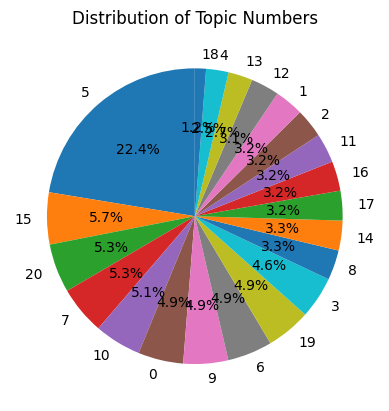

In [203]:
# Examine what percent of questions fit into what categories
# Count the occurrences of each unique value in the "topic_num" column
topic_counts = df_topics_21['topic_num'].value_counts()

# Plot a pie chart
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Topic Numbers')
plt.show()

In [215]:
# Make a frequency table of topics sorted by percent of the dataset

# Group by both "topic_count" and "topics" and count occurrences
frequency_table = df_topics_21.groupby(['topics']).size().reset_index(name='count')

# Calculate the total count for each "topic_count"
total = frequency_table['count'].sum()

# Add a column for the percentage
frequency_table['percentage'] = round((frequency_table['count'] / total) * 100, 2)

# Display the frequency table with percentage
frequency_table_sorted = frequency_table.sort_values(by='count', ascending=False)
frequency_table_sorted

,topics,count,percentage
3,envelope stamp angeles self address los po box...,5740,22.40
19,work job pay money help time bill co office wo...,1455,5.68
10,man women men woman sex meet marry young singl...,1367,5.34
7,home house live leave visit time dinner stay n...,1351,5.27
5,friend friends best friendship party close goo...,1310,5.11
13,people letter question read answer hear person...,1265,4.94
1,children parent kid child age grandchildren da...,1256,4.90
8,husband law marry marriage children years laws...,1256,4.90
4,family sister brother members law sisters memb...,1248,4.87
20,years ago marry divorce marriage live five mon...,1172,4.57


In [220]:
# Export the tables generated
frequency_table_sorted.to_csv('./frequency_table_sorted.csv')
df_topics_21.to_csv('./questions_in_21topics_nmf.csv')

In [224]:
# Pickle some of these models
joblib.dump(nmf_21, '../nmf_21.pkl')
joblib.dump(nmf, '../nmf_4.pkl')
joblib.dump(lda_model_2, '../lda_2.pkl')

['../lda_2.pkl']